# Imports:

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
from sklearn.preprocessing import normalize,MinMaxScaler
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline

# Data Pre-processing

### Load Data

In [3]:
train = pd.read_csv('train.csv')#.select_dtypes(exclude=['object'])
test = pd.read_csv('test.csv')#.select_dtypes(exclude=['object'])

#look into datatypes of the file
print("data types count")
train.dtypes.groupby(train.dtypes).count()


data types count


int64      35
float64     3
object     43
dtype: int64

In [4]:
# #selecting target
# train_target = train.SalePrice
# #the last column is the SalePrice coloumn so removing it from the list
# train_attrib = train.drop(train.columns[-1],axis=1)
# # droping id
# train_attrib = train_attrib.drop('Id',axis=1)
# test_attrib = test.drop('Id',axis=1)


### Looking into data

In [5]:
print('show sample')
train.head()

show sample


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
print('description of data')
train.describe()

description of data


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


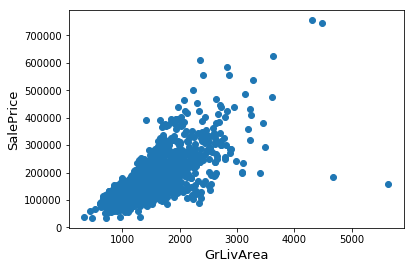

In [7]:

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

 There are a few houses with more than 4000 sq ft living area that are
 outliers, so we drop them from the training data.

In [8]:
train.drop(train[train["GrLivArea"] > 4000].index, inplace=True)

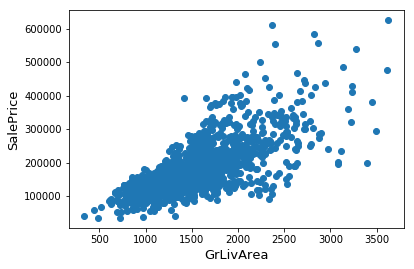

In [9]:
#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### RMSE

In [10]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Imputing missing data
filling in missing LotFrontage values by the median

In [11]:
lot_frontage_by_neighborhood = train["LotFrontage"].groupby(train["Neighborhood"])

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def factorize(df, factor_df, column, fill_na=None):
    factor_df[column] = df[column]
    if fill_na is not None:
        factor_df[column].fillna(fill_na, inplace=True)
    le.fit(factor_df[column].unique())
    factor_df[column] = le.transform(factor_df[column])
    return factor_df

### common data processing:
In this part we have lebel encoded some of the columns because some features are ordinal. I replaced some null value with zero because in those case they probably meant that it may not exist . Finally we have merged some of the features to get a better feature. 

In [13]:
def data_process(df):
    all_df = pd.DataFrame(index = df.index)
    
#     #set all NA column of numerical column to 0
#     col_numeric = df.select_dtypes(exclude=['object']).columns
#     all_df[col_numeric] = df[col_numeric]
#     all_df[col_numeric].fillna(0, inplace=True)
    
    
    
    
    
    
    
    
    all_df["LotFrontage"] = df["LotFrontage"]   
    for key, group in lot_frontage_by_neighborhood:
        idx = (df["Neighborhood"] == key) & (df["LotFrontage"].isnull())
        all_df.loc[idx, "LotFrontage"] = group.median()    
        
        
        all_df["LotArea"] = df["LotArea"]

    all_df["MasVnrArea"] = df["MasVnrArea"]
    all_df["MasVnrArea"].fillna(0, inplace=True)
   
    all_df["BsmtFinSF1"] = df["BsmtFinSF1"]
    all_df["BsmtFinSF1"].fillna(0, inplace=True)

    all_df["BsmtFinSF2"] = df["BsmtFinSF2"]
    all_df["BsmtFinSF2"].fillna(0, inplace=True)

    all_df["BsmtUnfSF"] = df["BsmtUnfSF"]
    all_df["BsmtUnfSF"].fillna(0, inplace=True)

    all_df["TotalBsmtSF"] = df["TotalBsmtSF"]
    all_df["TotalBsmtSF"].fillna(0, inplace=True)

    all_df["1stFlrSF"] = df["1stFlrSF"]
    all_df["2ndFlrSF"] = df["2ndFlrSF"]
    all_df["GrLivArea"] = df["GrLivArea"]
    
    all_df["GarageArea"] = df["GarageArea"]
    all_df["GarageArea"].fillna(0, inplace=True)

    all_df["WoodDeckSF"] = df["WoodDeckSF"]
    all_df["OpenPorchSF"] = df["OpenPorchSF"]
    all_df["EnclosedPorch"] = df["EnclosedPorch"]
    all_df["3SsnPorch"] = df["3SsnPorch"]
    all_df["ScreenPorch"] = df["ScreenPorch"]
    
    all_df["BsmtFullBath"] = df["BsmtFullBath"]
    all_df["BsmtFullBath"].fillna(0, inplace=True)

    all_df["BsmtHalfBath"] = df["BsmtHalfBath"]
    all_df["BsmtHalfBath"].fillna(0, inplace=True)

    all_df["FullBath"] = df["FullBath"] 
    all_df["HalfBath"] = df["HalfBath"] 
    all_df["BedroomAbvGr"] = df["BedroomAbvGr"] 
    all_df["KitchenAbvGr"] = df["KitchenAbvGr"] 
    all_df["TotRmsAbvGrd"] = df["TotRmsAbvGrd"] 
    all_df["Fireplaces"] = df["Fireplaces"] 

    all_df["GarageCars"] = df["GarageCars"]
    all_df["GarageCars"].fillna(0, inplace=True)

    all_df["CentralAir"] = (df["CentralAir"] == "Y") * 1.0
   
    all_df["OverallQual"] = df["OverallQual"]
    all_df["OverallCond"] = df["OverallCond"]

    
    """following case are ordinal so we are performing label encoding here"""
    nan = float('nan')
    qual_dict = {nan: 0, "NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
    all_df["ExterQual"] = df["ExterQual"].map(qual_dict).astype(int)
    all_df["ExterCond"] = df["ExterCond"].map(qual_dict).astype(int)
    all_df["BsmtQual"] = df["BsmtQual"].map(qual_dict).astype(int)
    all_df["BsmtCond"] = df["BsmtCond"].map(qual_dict).astype(int)
    all_df["HeatingQC"] = df["HeatingQC"].map(qual_dict).astype(int)
    all_df["KitchenQual"] = df["KitchenQual"].map(qual_dict).astype(int)
    all_df["FireplaceQu"] = df["FireplaceQu"].map(qual_dict).astype(int)
    all_df["GarageQual"] = df["GarageQual"].map(qual_dict).astype(int)
    all_df["GarageCond"] = df["GarageCond"].map(qual_dict).astype(int)

    all_df["BsmtExposure"] = df["BsmtExposure"].map(
        {nan: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

    bsmt_fin_dict = {nan: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
    all_df["BsmtFinType1"] = df["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
    all_df["BsmtFinType2"] = df["BsmtFinType2"].map(bsmt_fin_dict).astype(int)

    all_df["Functional"] = df["Functional"].map(
        {nan: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

    all_df["GarageFinish"] = df["GarageFinish"].map(
        {nan: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)

    all_df["Fence"] = df["Fence"].map(
        {nan: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)

    all_df["PoolQC"] = df["PoolQC"].map(qual_dict).astype(int)
    
    all_df["YearBuilt"] = df["YearBuilt"]
    all_df["YearRemodAdd"] = df["YearRemodAdd"]

    all_df["GarageYrBlt"] = df["GarageYrBlt"]
    all_df["GarageYrBlt"].fillna(0.0, inplace=True)

    all_df["MoSold"] = df["MoSold"]
    all_df["YrSold"] = df["YrSold"]
    
    all_df["LowQualFinSF"] = df["LowQualFinSF"]
    all_df["MiscVal"] = df["MiscVal"]

    all_df["PoolQC"] = df["PoolQC"].map(qual_dict).astype(int)

    all_df["PoolArea"] = df["PoolArea"]
    all_df["PoolArea"].fillna(0, inplace=True)
    
    # Add categorical features as numbers too. It seems to help a bit.
    all_df = factorize(df, all_df, "MSSubClass")
    all_df = factorize(df, all_df, "MSZoning", "RL")
    all_df = factorize(df, all_df, "LotConfig")
    all_df = factorize(df, all_df, "Neighborhood")
    all_df = factorize(df, all_df, "Condition1")
    all_df = factorize(df, all_df, "BldgType")
    all_df = factorize(df, all_df, "HouseStyle")
    all_df = factorize(df, all_df, "RoofStyle")
    all_df = factorize(df, all_df, "Exterior1st", "Other")
    all_df = factorize(df, all_df, "Exterior2nd", "Other")
    all_df = factorize(df, all_df, "MasVnrType", "None")
    all_df = factorize(df, all_df, "Foundation")
    all_df = factorize(df, all_df, "SaleType", "Oth")
    all_df = factorize(df, all_df, "SaleCondition")

    # IR2 and IR3 don't appear that often, so just make a distinction
    # between regular and irregular.
    all_df["IsRegularLotShape"] = (df["LotShape"] == "Reg") * 1

    # Most properties are level; bin the other possibilities together
    # as "not level".
    all_df["IsLandLevel"] = (df["LandContour"] == "Lvl") * 1

    # Most land slopes are gentle; treat the others as "not gentle".
    all_df["IsLandSlopeGentle"] = (df["LandSlope"] == "Gtl") * 1

    # Most properties use standard circuit breakers.
    all_df["IsElectricalSBrkr"] = (df["Electrical"] == "SBrkr") * 1

    # About 2/3rd have an attached garage.
    all_df["IsGarageDetached"] = (df["GarageType"] == "Detchd") * 1

    # Most have a paved drive. Treat dirt/gravel and partial pavement
    # as "not paved".
    all_df["IsPavedDrive"] = (df["PavedDrive"] == "Y") * 1

    # The only interesting "misc. feature" is the presence of a shed.
    all_df["HasShed"] = (df["MiscFeature"] == "Shed") * 1.  

    # If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
    all_df["Remodeled"] = (all_df["YearRemodAdd"] != all_df["YearBuilt"]) * 1
    
    # Did a remodeling happen in the year the house was sold?
    all_df["RecentRemodel"] = (all_df["YearRemodAdd"] == all_df["YrSold"]) * 1
    
    # Was this house sold in the year it was built?
    all_df["VeryNewHouse"] = (all_df["YearBuilt"] == all_df["YrSold"]) * 1

    all_df["Has2ndFloor"] = (all_df["2ndFlrSF"] == 0) * 1
    all_df["HasMasVnr"] = (all_df["MasVnrArea"] == 0) * 1
    all_df["HasWoodDeck"] = (all_df["WoodDeckSF"] == 0) * 1
    all_df["HasOpenPorch"] = (all_df["OpenPorchSF"] == 0) * 1
    all_df["HasEnclosedPorch"] = (all_df["EnclosedPorch"] == 0) * 1
    all_df["Has3SsnPorch"] = (all_df["3SsnPorch"] == 0) * 1
    all_df["HasScreenPorch"] = (all_df["ScreenPorch"] == 0) * 1
    
    # Months with the largest number of deals may be significant.
#     mx = max(train["MoSold"].groupby(train["MoSold"]).count())
#     all_df["HighSeason"] = df["MoSold"].replace(
#         train["MoSold"].groupby(train["MoSold"]).count()/mx)

#     mx = max(train["MSSubClass"].groupby(train["MSSubClass"]).count())
#     all_df["NewerDwelling"] = df["MSSubClass"].replace(
#         train["MSSubClass"].groupby(train["MSSubClass"]).count()/mx)  

        # Months with the largest number of deals may be significant.
    all_df["HighSeason"] = df["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

    all_df["NewerDwelling"] = df["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   
    
    
    all_df.loc[df.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
    all_df["Neighborhood_Good"].fillna(0, inplace=True)
    
    # House completed before sale or not
    all_df["SaleCondition_PriceDown"] = df.SaleCondition.replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

    # House completed before sale or not
    all_df["BoughtOffPlan"] = df.SaleCondition.replace(
        {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
    
    all_df["BadHeating"] = df.HeatingQC.replace(
        {'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

    area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
    all_df["TotalArea"] = all_df[area_cols].sum(axis=1)

    all_df["TotalArea1st2nd"] = all_df["1stFlrSF"] + all_df["2ndFlrSF"]

    all_df["Age"] = 2010 - all_df["YearBuilt"]
    all_df["TimeSinceSold"] = 2010 - all_df["YrSold"]

    all_df["SeasonSold"] = all_df["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                  6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    
    all_df["YearsSinceRemodel"] = all_df["YrSold"] - all_df["YearRemodAdd"]
    
    # Simplifications of existing features into bad/average/good.
    all_df["SimplOverallQual"] = all_df.OverallQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    all_df["SimplOverallCond"] = all_df.OverallCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    all_df["SimplPoolQC"] = all_df.PoolQC.replace(
        {1 : 1, 2 : 1, 3 : 2, 4 : 2})
    all_df["SimplGarageCond"] = all_df.GarageCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplGarageQual"] = all_df.GarageQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplFireplaceQu"] = all_df.FireplaceQu.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplFireplaceQu"] = all_df.FireplaceQu.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplFunctional"] = all_df.Functional.replace(
        {1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
    all_df["SimplKitchenQual"] = all_df.KitchenQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplHeatingQC"] = all_df.HeatingQC.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplBsmtFinType1"] = all_df.BsmtFinType1.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    all_df["SimplBsmtFinType2"] = all_df.BsmtFinType2.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    all_df["SimplBsmtCond"] = all_df.BsmtCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplBsmtQual"] = all_df.BsmtQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplExterCond"] = all_df.ExterCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplExterQual"] = all_df.ExterQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
            
    # Bin by neighborhood (a little arbitrarily). Values were computed by: 
    # train_df["SalePrice"].groupby(train_df["Neighborhood"]).median().sort_values()
    neighborhood_map = {
        "MeadowV" : 0,  #  88000
        "IDOTRR" : 1,   # 103000
        "BrDale" : 1,   # 106000
        "OldTown" : 1,  # 119000
        "Edwards" : 1,  # 119500
        "BrkSide" : 1,  # 124300
        "Sawyer" : 1,   # 135000
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "NAmes" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179900
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 182900
        "Blmngtn" : 2,  # 191000
        "CollgCr" : 2,  # 197200
        "ClearCr" : 3,  # 200250
        "Crawfor" : 3,  # 200624
        "Veenker" : 3,  # 218000
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 228475
        "StoneBr" : 4,  # 278000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 315000
    }

    all_df["NeighborhoodBin"] = df["Neighborhood"].map(neighborhood_map)
    return all_df

In [14]:
train_processed = data_process(train)
test_processed = data_process(test)

print("shape of train :" , train_processed.shape)
print("shape of test :" , test_processed.shape)


shape of train : (1456, 111)
shape of test : (1459, 111)


Keeping NeighborhoodBin into a temporary DataFrame because we want to use the unscaled version later on (to one-hot encode it). 

In [15]:
# Keeping NeighborhoodBin into a temporary DataFrame because we want to use the
# unscaled version later on (to one-hot encode it). 
neighborhood_bin_train = pd.DataFrame(index = train.index)
neighborhood_bin_train["NeighborhoodBin"] = train_processed["NeighborhoodBin"]
neighborhood_bin_test = pd.DataFrame(index = test.index)
neighborhood_bin_test["NeighborhoodBin"] = test_processed["NeighborhoodBin"]


## Skewness & Normalization

### skewness train set

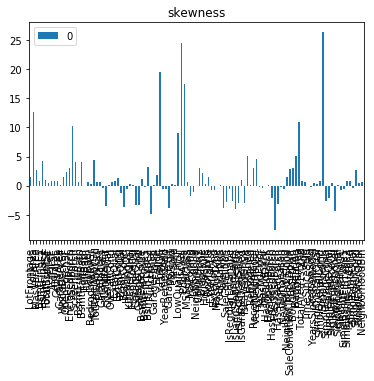

In [16]:
from scipy.stats import skew
numeric_features = train_processed.dtypes[train_processed.dtypes != "object"].index

skewness = train_processed[numeric_features].skew(axis=0 , skipna =True)
pd.DataFrame(skewness).plot.bar(title = "skewness")

# print('skew: ',train_processed[numeric_features].skew())

In [17]:
numeric_features = train_processed.dtypes[train_processed.dtypes != "object"].index

# Transform the skewed numeric features by taking log(feature + 1).
# This will make the features more normal.
from scipy.stats import skew

skewed = train_processed[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index

train_processed[skewed] = np.log1p(train_processed[skewed])


# Additional processing: scale the data.   
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(train_processed[numeric_features])

for i, col in enumerate(numeric_features):
    train_processed[col] = scaled[:, i]

/home/navid/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/navid/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


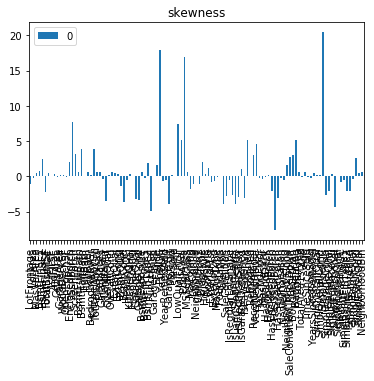

In [18]:
from scipy.stats import skew
numeric_features = train_processed.dtypes[train_processed.dtypes != "object"].index

skewness = train_processed[numeric_features].skew(axis=0 , skipna =True)
pd.DataFrame(skewness).plot.bar(title = "skewness")

# print('skew: ',train_processed[numeric_features].skew())

### Test Skewness

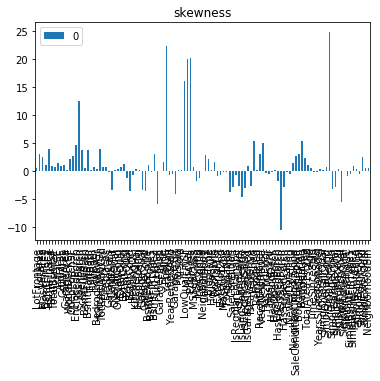

In [ ]:
numeric_features = test_processed.dtypes[train_processed.dtypes != "object"].index
skewness = test_processed[numeric_features].skew(axis=0 , skipna =True)
pd.DataFrame(skewness).plot.bar(title = "skewness")

# print('skew: ',test_processed[numeric_features].skew())

In [ ]:
numeric_features = test_processed.dtypes[train_processed.dtypes != "object"].index

# Transform the skewed numeric features by taking log(feature + 1).
# This will make the features more normal.
from scipy.stats import skew

skewed = test_processed[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index

test_processed[skewed] = np.log1p(test_processed[skewed])

# Additional processing: scale the data.   
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled = scaler.fit_transform(test_processed[numeric_features])
for i, col in enumerate(numeric_features):
    test_processed[col] = scaled[:, i]

/home/navid/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/navid/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Additional processing to scale the data.   

### One hot encoding
To encode categorical integer features as a one-hot numeric array we are using one hot encoding. This will transform each value of catagories into a features and make those a column value of dataframe. Finally put binary values in the rows of those column.

In [ ]:
# for example:

# ╔════════════╦═════════════════╦════════╗ 
# ║ CompanyName Categoricalvalue ║ Price  ║
# ╠════════════╬═════════════════╣════════║ 
# ║ VW         ╬      1          ║ 20000  ║
# ║ Acura      ╬      2          ║ 10011  ║
# ║ Honda      ╬      3          ║ 50000  ║
# ║ Honda      ╬      3          ║ 10000  ║
# ╚════════════╩═════════════════╩════════╝

# converting it to one Hot encoding:

# ╔════╦══════╦══════╦════════╦
# ║ VW ║ Acura║ Honda║ Price  ║
# ╠════╬══════╬══════╬════════╬
# ║ 1  ╬ 0    ╬ 0    ║ 20000  ║
# ║ 0  ╬ 1    ╬ 0    ║ 10011  ║
# ║ 0  ╬ 0    ╬ 1    ║ 50000  ║
# ║ 0  ╬ 0    ╬ 1    ║ 10000  ║
# ╚════╩══════╩══════╩════════╝

# refrence: https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

In this section at first we merge train and test data (variable name predictor_cols and predictor_cols_test). We did it because there is some fetures in train data which is missing in test data again same thing can happen for test data too. 

In [ ]:
# Convert categorical features using one-hot encoding.
def onehot(onehot_df, df, column_name, fill_na, drop_name):
    onehot_df[column_name] = df[column_name]
    if fill_na is not None:
        onehot_df[column_name].fillna(fill_na, inplace=True)

    dummies = pd.get_dummies(onehot_df[column_name], prefix="_" + column_name)

    onehot_df = onehot_df.join(dummies)
    onehot_df = onehot_df.drop([column_name], axis=1)
    return onehot_df


performing one hot

In [ ]:

def proceed_onehot(df):
    onehot_df = pd.DataFrame(index = df.index)

    onehot_df = onehot(onehot_df, df, "MSSubClass", None, "40")
    onehot_df = onehot(onehot_df, df, "MSZoning", "RL", "RH")
    onehot_df = onehot(onehot_df, df, "LotConfig", None, "FR3")
    onehot_df = onehot(onehot_df, df, "Neighborhood", None, "OldTown")
    onehot_df = onehot(onehot_df, df, "Condition1", None, "RRNe")
    onehot_df = onehot(onehot_df, df, "BldgType", None, "2fmCon")
    onehot_df = onehot(onehot_df, df, "HouseStyle", None, "1.5Unf")
    onehot_df = onehot(onehot_df, df, "RoofStyle", None, "Shed")
    onehot_df = onehot(onehot_df, df, "Exterior1st", "VinylSd", "CBlock")
    onehot_df = onehot(onehot_df, df, "Exterior2nd", "VinylSd", "CBlock")
    onehot_df = onehot(onehot_df, df, "Foundation", None, "Wood")
    onehot_df = onehot(onehot_df, df, "SaleType", "WD", "Oth")
    onehot_df = onehot(onehot_df, df, "SaleCondition", "Normal", "AdjLand")

    # Fill in missing MasVnrType for rows that do have a MasVnrArea.
    temp_df = df[["MasVnrType", "MasVnrArea"]].copy()
    idx = (df["MasVnrArea"] != 0) & ((df["MasVnrType"] == "None") | (df["MasVnrType"].isnull()))
    temp_df.loc[idx, "MasVnrType"] = "BrkFace"
    onehot_df = onehot(onehot_df, temp_df, "MasVnrType", "None", "BrkCmn")

    # Also add the booleans from calc_df as dummy variables.
    onehot_df = onehot(onehot_df, df, "LotShape", None, "IR3")
    onehot_df = onehot(onehot_df, df, "LandContour", None, "Low")
    onehot_df = onehot(onehot_df, df, "LandSlope", None, "Sev")
    onehot_df = onehot(onehot_df, df, "Electrical", "SBrkr", "FuseP")
    onehot_df = onehot(onehot_df, df, "GarageType", "None", "CarPort")
    onehot_df = onehot(onehot_df, df, "PavedDrive", None, "P")
    onehot_df = onehot(onehot_df, df, "MiscFeature", "None", "Othr")

    # Features we can probably ignore (but want to include anyway to see
    # if they make any positive difference).
    # Definitely ignoring Utilities: all records are "AllPub", except for
    # one "NoSeWa" in the train set and 2 NA in the test set.
    onehot_df = onehot(onehot_df, df, "Street", None, "Grvl")
    onehot_df = onehot(onehot_df, df, "Alley", "None", "Grvl")
    onehot_df = onehot(onehot_df, df, "Condition2", None, "PosA")
    onehot_df = onehot(onehot_df, df, "RoofMatl", None, "WdShake")
    onehot_df = onehot(onehot_df, df, "Heating", None, "Wall")

    # I have these as numerical variables too.
    onehot_df = onehot(onehot_df, df, "ExterQual", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "ExterCond", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "BsmtQual", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "BsmtCond", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "HeatingQC", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "KitchenQual", "TA", "Ex")
    onehot_df = onehot(onehot_df, df, "FireplaceQu", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "GarageQual", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "GarageCond", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "PoolQC", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "BsmtExposure", "None", "Gd")
    onehot_df = onehot(onehot_df, df, "BsmtFinType1", "None", "GLQ")
    onehot_df = onehot(onehot_df, df, "BsmtFinType2", "None", "GLQ")
    onehot_df = onehot(onehot_df, df, "Functional", "Typ", "Typ")
    onehot_df = onehot(onehot_df, df, "GarageFinish", "None", "Fin")
    onehot_df = onehot(onehot_df, df, "Fence", "None", "MnPrv")
    onehot_df = onehot(onehot_df, df, "MoSold", None, None)
    
    # Divide up the years between 1871 and 2010 in slices of 20 years.
    year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))

    yearbin_df = pd.DataFrame(index = df.index)
    yearbin_df["GarageYrBltBin"] = df.GarageYrBlt.map(year_map)
    yearbin_df["GarageYrBltBin"].fillna("NoGarage", inplace=True)

    yearbin_df["YearBuiltBin"] = df.YearBuilt.map(year_map)
    yearbin_df["YearRemodAddBin"] = df.YearRemodAdd.map(year_map)
    
    onehot_df = onehot(onehot_df, yearbin_df, "GarageYrBltBin", None, None)
    onehot_df = onehot(onehot_df, yearbin_df, "YearBuiltBin", None, None)
    onehot_df = onehot(onehot_df, yearbin_df, "YearRemodAddBin", None, None)

    return onehot_df

# Add the one-hot encoded categorical features.
onehot_df = proceed_onehot(train)
onehot_df = onehot(onehot_df, neighborhood_bin_train, "NeighborhoodBin", None, None)
train_processed = train_processed.join(onehot_df)


These onehot columns are missing in the test data, so drop them from the training data or we might overfit on them.

In [ ]:
drop_cols = [
                "_Exterior1st_ImStucc", "_Exterior1st_Stone",
                "_Exterior2nd_Other","_HouseStyle_2.5Fin", 
            
                "_RoofMatl_Membran", "_RoofMatl_Metal", "_RoofMatl_Roll",
                "_Condition2_RRAe", "_Condition2_RRAn", "_Condition2_RRNn",
                "_Heating_Floor", "_Heating_OthW",

                "_Electrical_Mix", 
                "_MiscFeature_TenC",
                "_GarageQual_Ex", "_PoolQC_Fa"
            ]
train_processed.drop(drop_cols, axis=1, inplace=True)

In [ ]:
onehot_df = proceed_onehot(test)
onehot_df = onehot(onehot_df, neighborhood_bin_test, "NeighborhoodBin", None, None)
test_processed = test_processed.join(onehot_df)

This column is missing in the training data. There is only one example with this value in the test set. So just drop it.

In [ ]:
test_processed.drop(["_MSSubClass_150"], axis=1, inplace=True)

Drop these columns. They are either not very helpful or they cause overfitting.

In [ ]:
drop_cols = [
    "_Condition2_PosN",    # only two are not zero
    "_MSZoning_C (all)",
    "_MSSubClass_160",
]
train_processed.drop(drop_cols, axis=1, inplace=True)
test_processed.drop(drop_cols, axis=1, inplace=True)

# log transform
We take the log here because the error metric is between the log of the
SalePrice and the log of the predicted price. That does mean we need to 
exp() the prediction to get an actual sale price.

In [ ]:
target = pd.DataFrame(index = train_processed.index, columns=["SalePrice"])
target["SalePrice"] = np.log(train["SalePrice"])
# train_processed.drop(["SalePrice"], axis=1, inplace=True)

print("Training set size:", train_processed.shape)
print("Test set size:", test_processed.shape)

Training set size: (1456, 403)
Test set size: (1459, 403)


# Split Data for training and testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_processed, 
                                                    target,
                                                    train_size=1, 
                                                    test_size=0, 
                                                    random_state=1)

#if want to use given test data
# X_test = test_processed


# Model selection

### Random Forest Regressor

In [ ]:
# my_model = RandomForestRegressor()

### DecisionTree

In [ ]:
# from sklearn.tree import DecisionTreeRegressor
# my_model = DecisionTreeRegressor()

### Xgboost 

* for 2000, 0.15 =>
mean absolute error:  14802.790788206335
accuracy score:  0.9184459671731471

* for 1000, 0.15 =>
mean absolute error:  14738.404430650686
accuracy score:  0.9185264791078522

* for 500, 0.15 =>
mean absolute error:  14709.338639768835
accuracy score:  0.918560790678001
* for 500, 0.05 =>
mean absolute error:  13994.730268086472
accuracy score:  0.9276053252581928
* for 1500, 0.05 =>
mean absolute error:  13527.634270654966
accuracy score:  0.9320158574642144

* for 1000, .05 =>
mean absolute error:  13607.276487585616
accuracy score:  0.932101661947708

* for 3000, .05 =>
mean absolute error:  13605.092010916096
accuracy score:  0.9322736091885926

In [ ]:
# from xgboost import XGBRegressor
# my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)


# Image("xgboost.jpg")

## Model fit on training set

In [ ]:
# my_model.fit(X_train, y_train)
# prediction = my_model.predict(X_test)

## Model fit for test set

# ANN

In [ ]:
learning_rate = 0.1
num_steps =25500
beta = .05 

hidden_1 = 256
hidden_2 = 128
hidden_3 = 64

input_dim = X_train.shape[1]  # Number of features
output_dim = 1              # Because it is a regression problem
#tf graph input
X_tf = tf.placeholder("float" )
y_tf = tf.placeholder("float" )

In [ ]:
weights = {
    'w1': tf.Variable(tf.random_normal([input_dim, hidden_1])),
    'w2': tf.Variable(tf.random_normal([hidden_1, hidden_2])),
    'w3': tf.Variable(tf.random_normal([hidden_2, hidden_3])),
    'out': tf.Variable(tf.random_normal([hidden_3, output_dim]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([hidden_1])),
    'b2': tf.Variable(tf.random_normal([hidden_2])),
    'b3': tf.Variable(tf.random_normal([hidden_3])),
    'out': tf.Variable(tf.random_normal([output_dim]))
}

In [ ]:
def ann_model(X_val):
  # Hidden layers
  layer_1 = tf.add(tf.matmul(X_val, weights['w1']), biases['b1'])
  layer_1 = tf.nn.relu(layer_1)
  
  layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
  layer_2 = tf.nn.relu(layer_2)
  
  layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
  layer_3 = tf.nn.relu(layer_3)
  
  # Output layer
  layer_out = tf.add(tf.matmul(layer_3, weights['out']), biases['out'])
  
  return layer_out

In [ ]:
# Model Construct
model = ann_model(X_tf)

# Mean Squared Error cost function
cost = tf.reduce_mean(tf.square(y_tf - model))
regularizer_1 = tf.nn.l2_loss(weights['w1'])
regularizer_2 = tf.nn.l2_loss(weights['w2'])
regularizer_3 = tf.nn.l2_loss(weights['w3'])
cost = tf.reduce_mean(cost + beta*regularizer_1 + beta*regularizer_2 + regularizer_3)

# Adam optimizer will update weights and biases after each step
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initialize variables 
init = tf.global_variables_initializer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()


In [ ]:
with tf.Session() as sess:
    #running initializer
    sess.run(init)
    for i in range(num_steps):
        sess.run(optimizer, feed_dict={X_tf:X_train, y_tf:y_train})
        if (i+1)%100 == 0:
            print("batch no : ",i+1)
            
    # Save the variables to disk.
    save_path = saver.save(sess, "/tmp/model.ckpt")
    print("Model saved in path: %s" % save_path)
    
    pred = sess.run(model, feed_dict={X_tf: X_test})
    prediction = pred.squeeze()

batch no :  100
batch no :  200
batch no :  300
batch no :  400
batch no :  500
batch no :  600
batch no :  700
batch no :  800
batch no :  900
batch no :  1000
batch no :  1100
batch no :  1200
batch no :  1300
batch no :  1400
batch no :  1500
batch no :  1600
batch no :  1700
batch no :  1800
batch no :  1900
batch no :  2000
batch no :  2100
batch no :  2200
batch no :  2300
batch no :  2400
batch no :  2500
batch no :  2600
batch no :  2700
batch no :  2800
batch no :  2900
batch no :  3000
batch no :  3100
batch no :  3200
batch no :  3300
batch no :  3400
batch no :  3500
batch no :  3600
batch no :  3700


# Acuracy Score

In [ ]:
print('ann root mean absolute error: ',rmse(y_test, prediction))
print('accuracy score: ',  r2_score(np.array(y_test),prediction) )

# Prepare Submission File

In [ ]:
prediction = np.exp(prediction)

pred_df = pd.DataFrame(prediction, index=test["Id"], columns=["SalePrice"])
pred_df.to_csv('output.csv', header=True, index_label='Id')


In [ ]:

# my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': prediction})
# # you could use any filename. We choose submission here
# my_submission.to_csv('submission.csv', index=False)

# Reference


## xgboost:
https://www.kaggle.com/dansbecker/xgboost

https://medium.com/@gabrieltseng/gradient-boosting-and-xgboost-c306c1bcfaf5



## regration + graph :
https://www.kaggle.com/janiobachmann/predicting-house-prices-regression-techniques


## Selecting and Filtering Data
https://www.kaggle.com/dansbecker/selecting-and-filtering-in-pandas

## Handling Missing Values
https://www.kaggle.com/dansbecker/handling-missing-values



## why use conditional probability coding
https://medium.com/airbnb-engineering/designing-machine-learning-models-7d0048249e69

## one hot encoding
https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

https://medium.com/@rajatgupta310198/getting-started-with-neural-network-for-regression-and-tensorflow-58ad3bd75223

## class example
https://colab.research.google.com/drive/1MExQ52bvHSPaUrGe8RvHZifvE6K6a0qh?fbclid=IwAR2EUWi4q6_q0mFbXQwGh4GNgB2Ex_WpP3K0L12182PdzszWSsEfzHf0REo#forceEdit=true&offline=true&sandboxMode=true&scrollTo=-Rh3-Vt9Nev9

## Some more
https://www.kaggle.com/klyusba/house-prices-advanced-regression-techniques/lasso-model-for-regression-problem/notebook

https://www.kaggle.com/juliencs/house-prices-advanced-regression-techniques/a-study-on-regression-applied-to-the-ames-dataset/ 

https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models

https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset